In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np

/home/rajeckidoyle/miniconda3/envs/my_torch_geometric/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Import Dataset

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_reverse_split_{split}.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
train_dataset = FingerprintDataset(split='train')
test_dataset = FingerprintDataset(split='test')

In [4]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config

no_of_epochs = best_config.GLOBALPARAMETERS['no_of_epochs']
train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = best_config.GLOBALPARAMETERS['valid_size']

In [6]:
#Get Model Parameters
hyperparameters = eval('best_config.'+'MLP_MDN'+'_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = train_dataset.x.shape[1]

## Define Model

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
model_params

{'has_edge_info': False,
 'batch_size': 32,
 'learning_rate': 4.13e-05,
 'model_layers': 3,
 'model_embedding_size': 64,
 'model_dense_neurons': 256,
 'model_linear_dropout_rate': 0.181,
 'model_embedding_dropout_rate': 0.193,
 'no_of_gaussians': 3,
 'feature_size': 1024}

In [9]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+'MLP_MDN'+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
MLP_MDN(
  (conv_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (initial_conv): Linear(in_features=1024, out_features=64, bias=True)
  (embedding_dropout): Dropout(p=0.193, inplace=False)
  (linear_dropout): Dropout(p=0.181, inplace=False)
  (readout1): Linear(in_features=64, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=3, bias=True)
  (readout2): Linear(in_features=64, out_features=256, bias=True)
  (sigma): Linear(in_features=256, out_features=3, bias=True)
  (readout3): Linear(in_features=64, out_features=256, bias=True)
  (alpha): Linear(in_features=256, out_features=3, bias=True)
)
126409


In [10]:
model = model.to(device)

In [11]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay=0.0001)  

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay=0.0001)  

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

## Training Loop

In [12]:
class Engine:
    def __init__(self, model, model_params, optimizer, device, loss_fn):
        self.model = model
        self.model_params = model_params
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn

    def train(self, loader):
        self.model.train()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):  
            fingerprint = fingerprint.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            mus, sigmas, alphas = self.model(fingerprint)
            loss = self.loss_fn(mus, labels, sigmas, alphas)
            # Backward and optimize
            self.optimizer.zero_grad()
            final_loss += loss.item()
            loss.backward()
            self.optimizer.step() 
        return final_loss / len(loader)
    '''
    def evaluate(self, loader):
            self.model.eval()
            # Enumerate over the data
            final_loss = 0
            for i, (fingerprint, labels) in enumerate(loader):  
                fingerprint = fingerprint.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass
                mus, sigmas, alphas = self.model(fingerprint)
                loss = self.loss_fn(mus, labels, sigmas, alphas)
                # Backward and optimize
                final_loss += loss.item()
            return final_loss / len(loader)
    '''

In [13]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import Categorical, Normal

def mdn_loss(mu, y, sigma, alphas):
    gmm = MixtureSameFamily(
            mixture_distribution=Categorical(probs=alphas),
            component_distribution=Normal(
                loc=mu,       
                scale=sigma))
    log_likelihood = gmm.log_prob(y.t())
    return -torch.mean(log_likelihood, axis=1)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

eng = Engine(model, model_params, optimizer, device, mdn_loss)

print("Starting training...")
losses = []
for epoch in range(no_of_epochs):
    loss = eng.train(train_loader)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 15.20319860859921
Epoch 10 | Train Loss 4.699041341480456
Epoch 20 | Train Loss 3.402106372933639
Epoch 30 | Train Loss 3.1024567390743054
Epoch 40 | Train Loss 2.9193517785323295
Epoch 50 | Train Loss 2.6884438866063167
Epoch 60 | Train Loss 2.3239567028848747
Epoch 70 | Train Loss 1.8894260839412087
Epoch 80 | Train Loss 1.6654293380285565
Epoch 90 | Train Loss 1.5975309892704612
Epoch 100 | Train Loss 1.5243908480594033
Epoch 110 | Train Loss 1.4375865867263393
Epoch 120 | Train Loss 1.4182850749869096
Epoch 130 | Train Loss 1.3708910440143787
Epoch 140 | Train Loss 1.2979595127858614
Epoch 150 | Train Loss 1.2844376814992804
Epoch 160 | Train Loss 1.2768574466830807
Epoch 170 | Train Loss 1.2492343532411676
Epoch 180 | Train Loss 1.2143408263984479
Epoch 190 | Train Loss 1.1914145632794029


## Evaluate on the Test Set

In [15]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import Categorical, Normal

import pandas as pd 
model.eval()
true_values = []
predictions = []
variance = []
alphas = []
with torch.no_grad():
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        mus, sigmas, alphas = model(fingerprint)
        gmm = MixtureSameFamily(
            mixture_distribution=Categorical(probs=alphas),
            component_distribution=Normal(
                loc=mus,       
                scale=sigmas))
        mean = gmm.mean.cpu().tolist()
        var = gmm.variance.cpu().tolist()
        labels = labels.cpu().tolist()
        predictions += mean
        true_values += labels
        variance += var
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values, 'variance': variance})
df['y_real'] = df['y_real'].apply(lambda x : x[0])
df

,y_pred,y_real,variance
0,6.759809,6.841638,0.544959
1,3.602256,4.533133,0.529036
2,6.699072,7.040958,0.623414
3,4.656194,5.244125,0.571655
4,6.946276,8.080922,0.661765
...,...,...,...
298,5.645339,5.207608,0.687781
299,5.122633,5.515700,0.655970
300,7.182846,7.017729,0.579458
301,4.090981,4.026872,0.584409


In [23]:
df.to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/datasets/MDN.csv')

## Model Evaluation

In [16]:
from sklearn import metrics

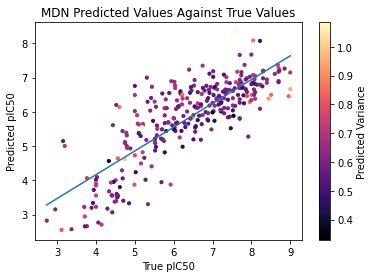

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data...
x = df["y_real"]
y = df["y_pred"]
color = df['variance']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

sc = plt.scatter(x, y, c=color, s=10, cmap='magma')
cbar = plt.colorbar(sc)
cbar.set_label('Predicted Variance')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('MDN Predicted Values Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/pvtMDN.jpeg', bbox_inches = 'tight', dpi=300)

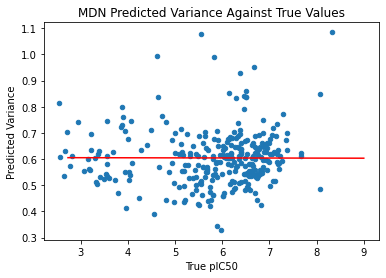

In [18]:
df.plot.scatter(x='y_pred',y='variance')
plt.plot(np.unique(df['y_real']), np.poly1d(np.polyfit(df['y_real'], df['variance'], 1))(np.unique(df['y_real'])), c='r')
plt.xlabel('True pIC50')
plt.ylabel('Predicted Variance')
plt.title('MDN Predicted Variance Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/varvtMDN.jpeg', bbox_inches = 'tight', dpi=300)

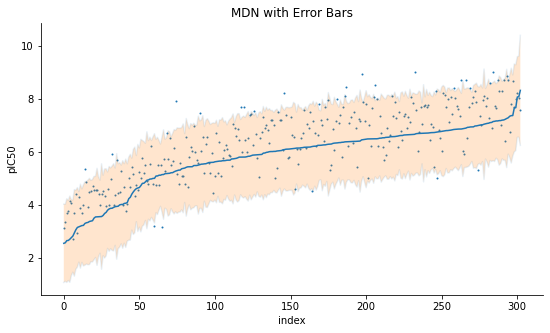

In [19]:
data_sorted_by_pred = df.sort_values('y_pred').reset_index()
# Define variables to plot
mu = data_sorted_by_pred['y_pred']
x = mu.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
y_std = df['variance']**0.5
error = 2*y_std
lower = mu - error
upper = mu + error

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(x, data_sorted_by_pred['y_real'], label='pred mean', s=1)
ax.plot(x, mu, label='pred mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('index')
ax.set_ylabel('pIC50')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('MDN with Error Bars')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/MDNerr.jpeg', bbox_inches = 'tight', dpi=300)

In [20]:
from sklearn import metrics
from scipy.stats import stats
def get_results(df):
    mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
    sc = stats.spearmanr(df["y_real"],df["y_pred"])[0]
    pc = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
    r = metrics.r2_score(df["y_real"],df["y_pred"])
    varcorr = np.corrcoef(df['y_real'], df['variance'])[0,1]

    results = {
        'Mean Square Error':mse,
        'Spearman':sc,
        'Pearson':pc,
        'R':r,
        'Variance Rho': varcorr,
    }
    results_df = pd.DataFrame([results])
    return results_df

get_results(df).to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/MDNresults.csv')

In [21]:
get_results(df)

,Mean Square Error,Spearman,Pearson,R,Variance Rho
0,0.958032,0.787527,0.813562,0.496228,-0.004158
